<h1 align="center">Deep Learning - Master in Deep Learning of UPM</h1> 

**IMPORTANTE**

Antes de empezar debemos instalar PyTorch Lightning, por defecto, esto valdría:

In [ ]:
!pip install pytorch-lightning

Además, si te encuentras ejecutando este código en Google Collab, lo mejor será que montes tu drive para tener acceso a los datos:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

<h1 align="center">RNNs I - Conceptos Fundamentales</h1> 

En esta sesión práctica de Redes Neuronales Recurrentes (RNNs) aprenderemos:
- Manejo de datos secuenciales
    - Como segmentar datasets secuenciales
    - Ventana deslizante
    - Horizonte de predicción
- Redes Neuronales Recurrentes
    - Obtener representación de la secuencias (pooling)
    - Como afectan w (sliding window) y h (horizonte) a la arquitectura
    - RNNs stackeadas

In [2]:
import datetime

import torch
import torch.nn as nn

import pytorch_lightning
import torchmetrics
from pytorch_lightning import seed_everything

import numpy as np

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt


DATA_PATH = 'data/sales.csv'
SEED = 42
seed_everything(seed=SEED) # Fijamos una semilla para reproducibilidad en los experimentos

Seed set to 42


42

Vamos practicar con un dataset que contiene registros a lo largo de 10 años (cada día) del número de ventas en una tienda. A considerar:
- Estamos ante un conjunto de datos secuencial (depende de t) y univariable.
- La variable _sold_ será a la vez feature y etiqueta, siendo nuestra "X" los pasados w registros de _sold_ y la etiqueta el futuro.

In [3]:
sales_df = pd.read_csv(DATA_PATH)
sales_df.head()

,date,sold
0,2010-01-01,801
1,2010-01-02,810
2,2010-01-03,818
3,2010-01-04,796
4,2010-01-05,808


In [4]:
sales_df['date'] = pd.to_datetime(sales_df['date'], format='%Y-%m-%d')
sales_df.sort_values('date', inplace=True)
print(f"Date range: {sales_df['date'].min()} to {sales_df['date'].max()}")

Date range: 2010-01-01 00:00:00 to 2019-12-31 00:00:00


Para crear el dataset necesitamos definir tanto el tamaño de ventana como el de horizonte

In [46]:
class SalesDataset(torch.utils.data.Dataset):
    def __init__(self, df, w=10, h=1):
        self.data = df.drop('date', axis=1).values
        self.w = w
        self.h = h

    def __len__(self):
        return len(self.data) - (self.w + self.h) + 1

    def __getitem__(self, idx):
        features = self.data[idx:idx+self.w] # [i: i+w)
        target = self.data[idx+self.w: idx+self.w+self.h] # [i+w, i+w+h)
        return features, target

Con ello ya podemos crear el DataModule de manera muy similar a como lo hacemos para datos tabulares.

El único cambio importante reside en como hacemos el particionado del dataset. No podemos hacer un particionado random ya que los datos necesitan estar en orden, por ello, los splits serán diferentes ventanas de tiempo ordenadas.

In [ ]:
class SalesDataModule(pytorch_lightning.LightningDataModule):
    def __init__(self, df, w=10, h=1, batch_size=16, val_size=0.2, test_size=0.2):
        super().__init__()
        self.train_df, self.val_df, self.test_df = self.sequential_train_val_test_split(df, val_size=val_size, test_size=test_size)
        self.scaler = self.normalize()

        self.w = w
        self.h = h

        self.batch_size = batch_size

    def setup(self, stage=None):
        if stage == 'fit':
            self.train_dataset = SalesDataset(self.train_df, w=self.w, h=self.h)
            self.val_dataset = SalesDataset(self.val_df, w=self.w, h=self.h)
        elif stage == 'test':
            self.test_dataset = SalesDataset(self.test_df, w=self.w, h=self.h)

    def sequential_train_val_test_split(self, df, val_size=0.2, test_size=0.2):
        # Aseguramos el formate de la fecha y ordenamos por ella
        df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
        df.sort_values('date', inplace=True)

        # Calculamos los índices para hacer los splits
        n = len(df)
        train_end = int((1 - val_size - test_size) * n)
        val_end = int((1 - test_size) * n)

        train = df.iloc[:train_end].copy()
        val = df.iloc[train_end:val_end].copy()
        test = df.iloc[val_end:].copy()

        return train, val, test
    
    def normalize(self):
        scaler = MinMaxScaler()
        self.train_df['sold'] = scaler.fit_transform(self.train_df['sold'].values.reshape(-1, 1))
        self.val_df['sold'] = scaler.transform(self.val_df['sold'].values.reshape(-1, 1))
        self.test_df['sold'] = scaler.transform(self.test_df['sold'].values.reshape(-1, 1))
        return scaler
    
    def collate_fn(self, batch):
        features, targets = zip(*batch)

        features = np.stack(features, axis=0)  # [batch_size, w, input_size]
        targets = np.stack(targets, axis=0)    # [batch_size, h, input_size]

        features = torch.tensor(features, dtype=torch.float32)
        targets = torch.tensor(targets, dtype=torch.float32)
        return features, targets
    
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, collate_fn=self.collate_fn)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, collate_fn=self.collate_fn)
    
    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, collate_fn=self.collate_fn)

Definiremos un modelo de regresión temporal (predicirá los h siguientes valores) basado en una RNN.

In [ ]:
class RNNRegressor(nn.Module):
    """
    RNN Regressor model
    h[int]: horizonte de predicción
    input_size[int]: variables de la serie temporal
    hidden_size[int]: tamaño de las capas ocultas de la RNN
    num_layers[int]: número de capas de la RNN (si > 1, stacking de células RNN)
    batch_first[bool]: si el batch_size es la primera dimensión
    p_drop[float]: probabilidad de dropout
    """
    def __init__(self, h=1, input_size=1, hidden_size=64, num_layers=1, batch_first=True, p_drop=0.0):
        super().__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=batch_first, dropout=p_drop)
        self.out = nn.Linear(hidden_size, h)
    
    def forward(self, x):
        outputs, _ = self.rnn(x) # [batch_size, seq_len, input_size] -> [batch_size, seq_len, hidden_size]
        pooled = outputs[:, -1, :] # last pooling
        return self.out(pooled) # [batch_size, hidden_size] -> [batch_size, 1]

Por comparativa, también definimos un modelo de regresión temporal basado en un básico MLP

In [25]:
class MLPRegressor(nn.Module):
    def __init__(self, w=10, h=1, input_size=1, hidden_size=64):
        super().__init__()
        input_dim = w * input_size # Aplanamos las secuencias

        self.fc1 = nn.Linear(input_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, h)  # Ahora produce 'h' salidas

        self.relu = nn.ReLU()

    def forward(self, x):
        # x: [batch_size, seq_len, input_size]
        x = x.view(x.size(0), -1) # x: [batch_size, seq_len * input_size]
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)  # out: [batch_size, h]
        return out

Esta celda es para experimentar como varía tanto el tamaño del modelo como el de salida si cambiamos los parámetros. Sé libre de experimentar y preguntarte porque ante ciertos cambios las dimensiones cambian y viceversa!

Probad a cambiar el tamaño de ventana comparando como crece el número de parámetros necesarios para modelar los datos!

In [30]:
input_size = 3
hidden_size = 64
batch_first = True
num_layers = 1

batch_size = 64
w = 10
h = 2

pooling = 'last'

rnn = RNNRegressor(h=h, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=batch_first, pooling=pooling)
mlp = MLPRegressor(w=w, h=h, input_size=input_size, hidden_size=hidden_size)

x = torch.randn(batch_size, w, input_size)

def stats(model, x):
    name = model.__class__.__name__
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print(f'Model: {name}')
    print(f'Model Parameters: {params}')
    print(f'Model Output Size: {model(x).size()}', end='\n\n')

stats(rnn, x)
stats(mlp, x)

Model: RNNRegressor
Model Parameters: 4546
Model Output Size: torch.Size([64, 2])

Model: MLPRegressor
Model Parameters: 6274
Model Output Size: torch.Size([64, 2])



Creemos nuestro LightningModule. Este recibirá directamente un modelo (nn.Module).

In [59]:
class SalesPredictor(pytorch_lightning.LightningModule):
    def __init__(self, model, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters() # guardamos la configuración de hiperparámetros
        self.learning_rate = learning_rate

        self.model = model

        self.criterion = nn.MSELoss()

        self.r2 = torchmetrics.R2Score()

    def forward(self, x):
        return self.model(x)
    
    def compute_batch(self, batch, split='train'):
        inputs, targets = batch
        output = self(inputs)

        preds = output.view(-1)
        targets = targets.view(-1)

        loss = self.criterion(preds, targets)
        self.log_dict(
            {
                f'{split}_loss': loss, 
                f'{split}_r2': self.r2(preds, targets), 
            }, 
            on_epoch=True, prog_bar=True)
        
        return loss
    
    def training_step(self, batch, batch_idx):
        return self.compute_batch(batch, 'train')
    
    def validation_step(self, batch, batch_idx):
        return self.compute_batch(batch, 'val')
    
    def test_step(self, batch, batch_idx):
        return self.compute_batch(batch, 'test')
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.learning_rate) # self.parameters() son los parámetros del modelo

In [ ]:
# Parámetros
SAVE_DIR = f'lightning_logs/sales/{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}'
w = 50
h = 3
batch_size = 64
num_layers = 1
hidden_size = 128
learning_rate = 1e-3
p_drop = 0.2

# DataModule
data = pd.read_csv(DATA_PATH)
data_module = SalesDataModule(data, w=w, h=h, batch_size=batch_size)

# Model (Probad a descomentar uno u otro)
model = RNNRegressor(h=h, input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, p_drop=p_drop)
# model = MLPRegressor(w=w, h=h, input_size=1, hidden_size=hidden_size)

# LightningModule
module = SalesPredictor(model, learning_rate=learning_rate)

# Callbacks
early_stopping_callback = pytorch_lightning.callbacks.EarlyStopping(
    monitor='val_loss', # monitorizamos la pérdida en el conjunto de validación
    mode='min', 
    patience=5, # número de epochs sin mejora antes de parar
    verbose=False, # si queremos que muestre mensajes del estado del early stopping 
)
model_checkpoint_callback = pytorch_lightning.callbacks.ModelCheckpoint(
    monitor='val_loss', # monitorizamos la pérdida en el conjunto de validación
    mode='min', # queremos minimizar la pérdida
    save_top_k=1, # guardamos solo el mejor modelo
    dirpath=SAVE_DIR, # directorio donde se guardan los modelos
    filename=f'best_model' # nombre del archivo
)

callbacks = [early_stopping_callback, model_checkpoint_callback]

# Loggers
csv_logger = pytorch_lightning.loggers.CSVLogger(
    save_dir=SAVE_DIR,
    name='metrics',
    version=None
)

loggers = [csv_logger] # se pueden poner varios loggers (mirar documentación)

# Trainer
trainer = pytorch_lightning.Trainer(max_epochs=50, accelerator='cpu', callbacks=callbacks, logger=loggers)

trainer.fit(module, data_module)
results = trainer.test(module, data_module)

Visualicemos con Matplotlib como están ajustando las predicciones del modelo a la realidad

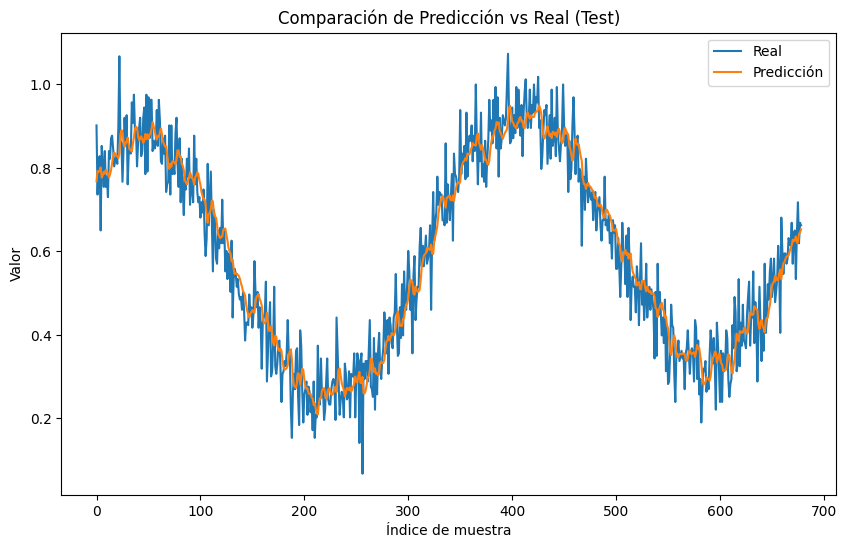

In [ ]:
all_preds = []
all_targets = []

# Iteramos sobre el test_dataloader
with torch.no_grad():
    for batch in data_module.test_dataloader():
        features, targets = batch
        # features: [batch_size, seq_len, input_size]
        # targets: [batch_size, horizon] (o [batch_size] si es un horizonte 1)
        features = features.to(module.device)
        targets = targets.to(module.device)
        
        preds = module(features)  # [batch_size, horizon] o [batch_size]
        
        # Guardamos predicciones y targets
        all_preds.append(preds.cpu())
        all_targets.append(targets.cpu())

# Concatenamos todos los batch para tener un solo tensor
# Si es horizonte > 1, puedes elegir un paso en particular o hacer promedio
# Ej: tomamos el primer paso:
all_preds = torch.cat(all_preds, dim=0)[:, 0]
all_targets = torch.cat(all_targets, dim=0)[:, 0]

# Utilizamos el scaler inverso para obtener los valores originales
# all_preds = dm.scaler_test.inverse_transform(all_preds.reshape(-1, 1)).flatten()
# all_targets = dm.scaler_test.inverse_transform(all_targets.reshape(-1, 1)).flatten()

# Ahora graficamos
plt.figure(figsize=(10, 6))
plt.plot(all_targets, label='Real')
plt.plot(all_preds, label='Predicción')
plt.title('Comparación de Predicción vs Real (Test)')
plt.xlabel('Índice de muestra')
plt.ylabel('Valor')
plt.legend()
plt.show()


# EXTRA: From Scratch RNN

In [126]:
STR2ACT = {
    'tanh' : nn.Tanh,
    'sigmoid': nn.Sigmoid,
    'relu' : nn.ReLU,
    'gelu' : nn.GELU
}

class RNN(nn.Module):
    """
    Implementation of a Recurrent Neural Network

    __init__()
    input_size[int]: features per timestep, if > 1 is multivariate
    hidden_size[int]: hidden size, normally between (64, 2056)
    num_layers[int]: number of rnn stacked cells, if > 1 is DeepRNN, normally between (1, 8)
    bidirectional[bool]: if the rnn is bidirectional
    bias[bool]: if input linear layers have bias

    forward()
    x[torch.Tensor]: model input of size [batch_size, seq_len, input_size]
    h[torch.Tensor]: initial hidden state of size [batch_size, seq_len, input_size], if None it will be zeros
    """
    def __init__(self, input_size, hidden_size, num_layers=1, bidirectional=False, bias=False, activation='tanh', p_drop=0.0):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.bias = bias
        self.p_drop = p_drop

        self.l2r = nn.ModuleList([self.rnn_layer(input_layer=(l==0)) for l in range(self.num_layers)]) # left to right RNN

        if bidirectional:
            self.r2l = nn.ModuleList([self.rnn_layer(input_layer=(l==0)) for l in range(self.num_layers)]) # right to left RNN

        self.activation = STR2ACT[activation]() # tanh by default


    def rnn_layer(self, input_layer=False):
        return nn.ModuleDict({
            'w_ih' : nn.Linear(self.input_size if input_layer else self.hidden_size, self.hidden_size, bias=self.bias),
            'w_hh' : nn.Linear(self.hidden_size, self.hidden_size),
            'drop' : nn.Dropout(self.p_drop)
        })
    
    def process_sequence(self, x, h, direction='l2r'):
        """
        In deep RNNs (num_layers > 1), hidden state is propagated as:
        - input hidden state of the next layer of the current timestep; h(l, t) -> h(l+1, t)
        - input hidden state of the current layer of the next timestep; h(l, t) -> h(l, t+1)
        """
        seq_len = x.size(0)
        layers = self.l2r if direction == 'l2r' else self.r2l

        output = []
        for t in range(seq_len):
            x_t = x[t] # input
            for l, layer in enumerate(layers):
                # h[l] here is the lth hidden state for t-1
                # when override it will be the lth hidden state for t
                h[l] = self.activation(
                    layer['w_ih'](x_t) + layer['w_hh'](h[l])
                )
                h[l] = layer['drop'](h[l]) # no dropout by default

                x_t = h[l] # also, it will be the input for the l+1th layer of t
            
            output.append(h[-1]) # final hidden state for timestep t
        
        return torch.stack(output).transpose(0, 1) # [seq_len, batch_size, hidden_size] -> [batch_size, seq_len, hidden_size]

    def forward(self, x, h=None):
        x = x.transpose(0, 1) # [batch_size, seq_len, input_size] -> [seq_len, batch_size, input_size]
        batch_size = x.size(1)

        if self.bidirectional:
            if h is None: # by default, hidden state is initialized to 0s
                h = x.new_zeros((2, self.num_layers, batch_size, self.hidden_size)) # same device and dtype as x
            
            h_l2r, h_r2l = h[0], h[1] # if h is passed in bidirectional it is assumed that the format is [2, num_layers, batch_size, hidden_size]
            
            l2r_output = self.process_sequence(x, h_l2r, direction='l2r')
            r2l_output = self.process_sequence(x.flip(dims=[-1]), h_r2l, direction='r2l')

            r2l_output = r2l_output.flip(dims=[-1]) # flip to get left to right context

            output = torch.cat([l2r_output, r2l_output], dim=-1) # [batch_size, seq_len, 2 * hidden_size]

        else:
            if h is None: # by default, hidden state is initialized to 0s
                h = x.new_zeros((self.num_layers, batch_size, self.hidden_size)) # same device and dtype as x
            
            output = self.process_sequence(x, h, direction='l2r') # [batch_size, seq_len, hidden_size]
        
        return output

In [127]:
input_size = 3
hidden_size = 128
num_layers = 3
batch_size = 2
seq_len = 10
bidirectional = True
bias = True
activation = 'tanh'
p_drop = 0.1


model = RNN(input_size, hidden_size, num_layers=num_layers, bidirectional=bidirectional, bias=bias, activation=activation, p_drop=p_drop)

x = torch.randn(batch_size, seq_len, input_size)

x.size(), model(x).size()

(torch.Size([2, 10, 3]), torch.Size([2, 10, 256]))